In [1]:
# Imports
import os
from datasets import load_dataset, Audio, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from torchvision import transforms
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image
from evaluate import load
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
model_name = "google/vit-base-patch16-224-in21k" 
processor = ViTImageProcessor.from_pretrained(model_name)
epochs = 30
training_args = {
    "output_dir": "./vit-base-manuai",
    "remove_unused_columns": False,
    "learning_rate": 5e-4,  # Harsh Learning rate for fine-tuning 
    "per_device_train_batch_size": 8,  # Batch size per device during training
    "fp16": False,  # Disable mixed precision training
    "bf16": False,  # Disable bfloat16 training
    #"no_cuda": True,  # Disable CUDA to avoid GPU memory issues
    "logging_steps": 10,
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "eval_strategy": "epoch",  # Evaluate at the end of each epoch
    "save_strategy": "epoch",  # Save model at the end of each epoch
    "save_total_limit": 3,  # Limit the number of saved checkpoints
    "label_names": ["labels"],
    #"weight_decay": 0.01,  # Weight decay for regularization
    "report_to": "tensorboard",
    "load_best_model_at_end": True,
}
n_proc = 1  # Number of processes for parallel processing
metric = load("accuracy")
training_size = int(input("Enter the amount of spectrograms per class to train on (0 for all, default 100): ") or 100)

In [3]:
"""
Load the dataset from the specified path and convert audio data into Mel Spectrograms.
Directory structure:
segments/
├── {english_name}
│   ├── {scientific_name}_{scientific_subspecie}
│   │   ├── {english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav
"""

def augment_audio(sample, force_augment=False):
    waveform, sample_rate = torchaudio.load(sample["audio"]["path"])

    if force_augment or random.random() < 0.7:
        # Apply pitch shifting
        if random.random() < 0.8:
            n_steps = random.uniform(-3, 3)
            waveform = T.PitchShift(sample_rate, n_steps=n_steps)(waveform)

        # Apply time stretching (correctly)
        if random.random() < 0.8:
            stretch_factor = random.uniform(0.8, 1.2)
            # Convert to spectrogram
            n_fft = 2048
            window = torch.hann_window(n_fft)
            hop_length = 512
            spec = torch.stft(
                waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True
            )
            # Apply TimeStretch
            time_stretch = T.TimeStretch(hop_length=hop_length, n_freq=spec.size(1))
            spec_stretched = time_stretch(spec, stretch_factor)
            # Convert back to waveform
            waveform = torch.istft(spec_stretched, n_fft=n_fft, hop_length=hop_length)

        # Add noise
        if random.random() < 0.5:
            noise = torch.randn_like(waveform) * 0.01
            waveform = waveform + noise

        # Apply frequency masking
        if random.random() < 0.5:
            waveform = T.FrequencyMasking(freq_mask_param=20)(waveform)

    sample["audio"] = {
        "array": waveform.detach().numpy(),
        "sampling_rate": sample_rate,
        "path": sample["audio"]["path"]
    }
    return sample

segments_path = "./segments"
output_dir = "./vit-base-manuai"

labels = set()

# Collect file paths by class
label_to_files = {}
for root, dirs, files in os.walk(segments_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            parts = os.path.splitext(file)[0].split('_')
            if len(parts) >= 2:
                english_name = parts[1]  # Extract label from filename
                labels.add(english_name)
                if english_name not in label_to_files:
                    label_to_files[english_name] = []
                label_to_files[english_name].append(path)

# Create dataset with up to training_size files per class
data = []
for label, files in label_to_files.items():
    random.shuffle(files)  # Randomize file order
    selected_files = files[:training_size]  # Select up to training_size
    # If not enough files, augment audio
    if len(selected_files) < training_size:
        augmented_samples = []
        while len(selected_files) + len(augmented_samples) < training_size:
            file = random.choice(selected_files)
            sample = {"audio": {"path": file}, "label": label}
            augmented_samples.append(augment_audio(sample, force_augment=True))
        selected_files.extend([s["audio"]["path"] for s in augmented_samples])
    # Add samples to data
    for file in selected_files[:training_size]:  # Ensure exactly training_size
        data.append({"audio": {"path": file}, "label": label})

# Create dataset
dataset = Dataset.from_list(data)

dataset = dataset.shuffle(seed=42)

# Cast audio column to use soundfile backend
dataset = dataset.cast_column("audio", Audio(decode=True, sampling_rate=44100))

if not dataset:
    print("🚨 Dataset could not be loaded. Check the dataset path and structure.")
if "audio" not in dataset.column_names:
    print("🚨 Dataset does not contain 'audio' column. Check the dataset structure.")

print(f"✅ Dataset loaded with {len(dataset)} samples.")
print(f"Sample audio file: {dataset[0]}")

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_43296/88895746.py:33: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pyto

✅ Dataset loaded with 10000 samples.
Sample audio file: {'audio': <datasets.features._torchcodec.AudioDecoder object at 0x306cc3d90>, 'label': 'kaka'}


In [4]:
def convert_to_mel_spectrogram(sample):
    """
    Convert audio data into Mel Spectrograms using torchaudio.
    """
    # Load audio file
    waveform = torch.tensor(sample["audio"]["array"]).unsqueeze(0)  # Add channel dimension
    sample_rate = sample["audio"]["sampling_rate"]
    
    # Resample if needed
    if sample_rate != 44100:
        resampler = T.Resample(sample_rate, 44100)
        waveform = resampler(waveform)
        sample_rate = 44100
    
    # Convert to mono if stereo (2 channels)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Create mel spectrogram transform
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048, # FFT size for STFT 
        hop_length=512, # Hop length for the STFT (default is n_fft // 4)
        win_length=2048, # Window length for the STFT (default is n_fft)
        n_mels=128, # Number of Mel bands
        f_min=50, # Minimum frequency for Mel filterbank 
        f_max=sample_rate // 2
    )
    
    mel_spec = mel_spectrogram_transform(waveform)
    amplitude_to_db = T.AmplitudeToDB()
    mel_spec_db = amplitude_to_db(mel_spec)
    
    # Convert to numpy and normalise
    mel_spec_np = mel_spec_db.squeeze().numpy()
    normalized = ((mel_spec_np - mel_spec_np.min()) / 
                (mel_spec_np.max() - mel_spec_np.min()) * 255).astype(np.uint8)
    
    # Convert to RGB image
    rgb_image = np.stack([normalized] * 3, axis=-1)
    sample["image"] = Image.fromarray(rgb_image)
    return sample

def extract_label(sample):
    """
    Extract labels from the dataset.
    The file names are formatted as '{bird_id}_{english_name}_{scientific_name}_{scientific_subspecie}_{song}_segment_{num}.wav'.
    """
    # Extract the label from the file name
    audio_path = sample["audio"]["path"]
    # Get just the filename without the path
    filename = os.path.basename(audio_path)
    # Remove the .wav extension
    filename_without_ext = os.path.splitext(filename)[0]
    # Split by underscore and get the english name (second element)
    parts = filename_without_ext.split('_')
    if len(parts) >= 2:
        english_name = parts[1]  # Second element is the English name
    else:
        # Fallback if filename doesn't match expected format
        english_name = "unknown"
    
    sample["class"] = english_name
    #print(f"Extracted label: {sample['label']} from filename: {filename}")
    return sample

def transform(sample):
    inputs = processor([x for x in sample["image"]], return_tensors="pt", do_normalize=True)
    augment = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
    ])
    inputs["pixel_values"] = torch.stack([augment(img) for img in inputs["pixel_values"]])
    label_to_id = {c: i for i, c in enumerate(labels)}
    inputs["label"] = [label_to_id[label] for label in sample["label"]]
    return inputs

print(f"✅ Unique labels found: {labels}")
# print contents of sample
print(f"Sample dataset entry: {dataset[0]['audio']}")

# Convert audio data into Mel Spectrograms
dataset = dataset.map(
    convert_to_mel_spectrogram, 
    remove_columns=["audio"],
    desc="Converting audio to Mel Spectrograms",
    num_proc=n_proc,  # Use multiple processes for faster processing
)
# Check if Mel Spectrograms are created correctly
if "image" not in dataset.column_names:
    print("🚨 Mel Spectrograms were not created correctly. Check the conversion logic.")
print(f"✅ Converted Mel Spectrograms for {len(dataset)} samples.")

# Transform the dataset for the model
dataset = dataset.with_transform(transform)
print("✅ Dataset transformed for model input.")

✅ Unique labels found: {'saddleback', 'tomtit', 'whitehead', 'morepork', 'fantail', 'kaka', 'robin', 'silvereye', 'bellbird', 'tui'}
Sample dataset entry: <datasets.features._torchcodec.AudioDecoder object at 0x3069e6090>


Converting audio to Mel Spectrograms: 100%|██████████| 10000/10000 [04:46<00:00, 34.91 examples/s] 

✅ Converted Mel Spectrograms for 10000 samples.
✅ Dataset transformed for model input.


In [5]:
# Training the model
def collate_fn(batch):
    """
    Custom collate function to handle variable-length inputs.
    """
    return {
        "pixel_values": torch.stack([item["pixel_values"] for item in batch]),
        "labels": torch.tensor([item["label"] for item in batch], dtype=torch.long)
    }

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

train, test = dataset.train_test_split(test_size=0.2, seed=42).values()

dataset_dict = DatasetDict({
    "train": train,
    "test": test,
})

processor = ViTImageProcessor.from_pretrained(model_name)

callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["classifier"],
    )

model = get_peft_model(model, lora_config)

trainer = Trainer(
    model=model,
    args=TrainingArguments(**training_args),
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    processing_class=processor,  
    callbacks=callbacks,  # Add early stopping callback
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")

print_trainable_parameters(model, "LoRA")

LoRA trainable parameters: 597,514/86,403,860 (0.69%)


In [7]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.091100,0.981090,0.684500
2,0.539100,0.742137,0.757000
3,0.643800,0.561027,0.823500
4,0.290700,0.501804,0.840000
5,0.395700,0.491737,0.849500
6,0.163500,0.430313,0.862000
7,0.302500,0.403596,0.883000
8,0.248000,0.462481,0.876500
9,0.105600,0.387408,0.896500
10,0.045500,0.372115,0.904000


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.war

***** train metrics *****
  epoch                    =         16.0
  total_flos               = 9302759340GF
  train_loss               =        0.318
  train_runtime            =   1:36:37.42
  train_samples_per_second =       41.398
  train_steps_per_second   =        5.175


In [8]:
print_model_size(output_dir)
metrics = trainer.evaluate(eval_dataset=dataset_dict['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Model Size: 2.7 MB


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


***** eval metrics *****
  epoch                   =       16.0
  eval_accuracy           =      0.919
  eval_loss               =      0.348
  eval_runtime            = 0:00:37.68
  eval_samples_per_second =     53.073
  eval_steps_per_second   =      6.634


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy per class:
saddleback: 0.92
tomtit: 0.96
whitehead: 0.91
morepork: 0.98
fantail: 0.95
kaka: 0.96
robin: 0.88
silvereye: 0.95
bellbird: 0.86
tui: 0.81


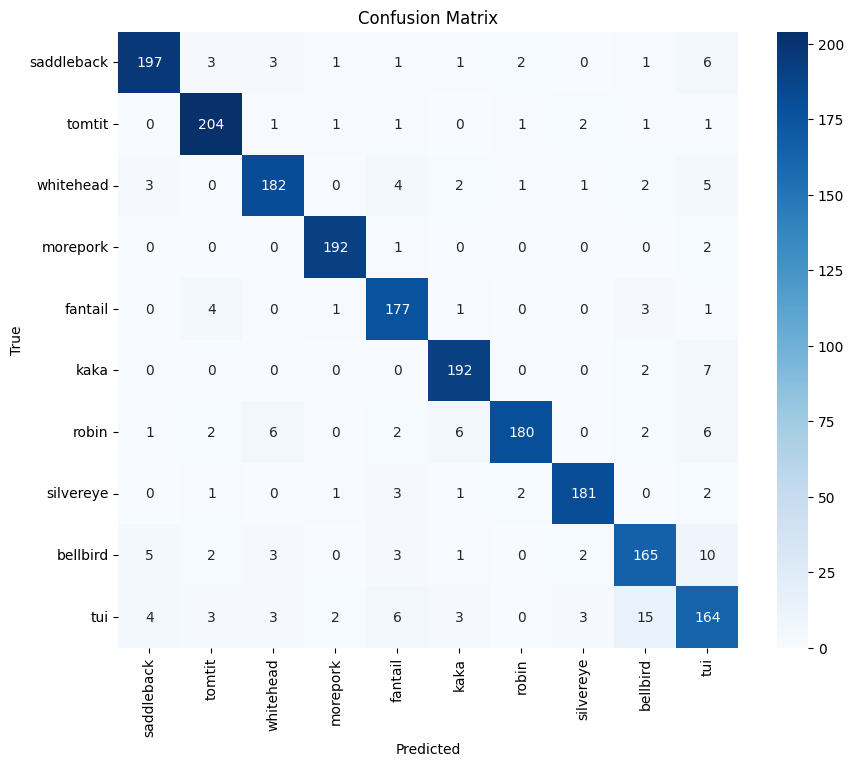

In [9]:
predictions = trainer.predict(dataset_dict['test'])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Accuracy per class
accuracy_per_class = {}
for i, label in enumerate(labels):
    accuracy = np.mean(y_pred[y_true == i] == i)
    accuracy_per_class[label] = accuracy

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
!zip -r vit-base-manuai.zip vit-base-manuai
print("Model saved as vit-base-manuai.zip")
print("Training complete. Model and metrics saved.")

updating: vit-base-manuai/ (stored 0%)
updating: vit-base-manuai/adapter_model.safetensors (deflated 8%)
updating: vit-base-manuai/train_results.json (deflated 37%)
updating: vit-base-manuai/checkpoint-15000/ (stored 0%)
updating: vit-base-manuai/checkpoint-15000/adapter_model.safetensors (deflated 8%)
updating: vit-base-manuai/checkpoint-15000/rng_state.pth (deflated 26%)
updating: vit-base-manuai/checkpoint-15000/optimizer.pt (deflated 8%)
updating: vit-base-manuai/checkpoint-15000/scheduler.pt (deflated 62%)
updating: vit-base-manuai/checkpoint-15000/README.md (deflated 66%)
updating: vit-base-manuai/checkpoint-15000/training_args.bin (deflated 53%)
updating: vit-base-manuai/checkpoint-15000/adapter_config.json (deflated 55%)
updating: vit-base-manuai/checkpoint-15000/trainer_state.json (deflated 85%)
updating: vit-base-manuai/checkpoint-15000/preprocessor_config.json (deflated 47%)
updating: vit-base-manuai/README.md (deflated 66%)
updating: vit-base-manuai/training_args.bin (defla